# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'1.0.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.iloc[shuffle], Y.iloc[shuffle]
#X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
def Q1():
        
### STUDENT START ###
    """
    Input: mini & dev train data and labels
    Purpose: understand the blurring influence on model accuracies
    """
    # create a smooth function
    def smooth(data):
        smoothed_data = []
        w = 9 # determine weight: 9 would give every pixel a equal weight
        data = data.to_numpy()
        
        for i in range(data.shape[0]):
            grid = data[i].reshape(28,28)       
            f = np.zeros([28,28])

            for i in range(28):
                for j in range(28):
                    # weighted combination of original and the 8 neighboring value
                    
                    f[i,j] = grid[i,j]/w + np.sum(grid[i-1:i+2, j-1:j+2])/w
            smoothed_data.append(f.flatten())
        return smoothed_data
    
    # create 1-Nearest Neighbor models
    knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
    
    mini_train_data_smooth = smooth(mini_train_data)
    dev_data_smooth = smooth(dev_data)
    
    # Model I: Do not use the filter
    knn.fit(mini_train_data,  mini_train_labels)
    score_model1 = knn.score(dev_data, dev_labels)
    print('Train no filter data - Accuracy:', score_model1)
    
    # Model II: Filter the training data but not the dev data
    knn.fit(mini_train_data_smooth,  mini_train_labels)
    score_model2 = knn.score(dev_data, dev_labels)
    print('Filter the training data but not the dev data - Accuracy:', score_model2)
    
    # Model III: Filter the dev data but not the training data
    knn.fit(mini_train_data,  mini_train_labels)
    score_model3 = knn.score(dev_data_smooth, dev_labels)
    print('Filter the dev data but not the training data - Accuracy:', score_model3)
    
    # Model IV: Filter both training data and dev data
    knn.fit(mini_train_data_smooth,  mini_train_labels)
    score_model4 = knn.score(dev_data_smooth, dev_labels)
    print('Filter both training data and dev data - Accuracy:', score_model4)
    
### STUDENT END ###

Q1()

Train no filter data - Accuracy: 0.884
Filter the training data but not the dev data - Accuracy: 0.899
Filter the dev data but not the training data - Accuracy: 0.879
Filter both training data and dev data - Accuracy: 0.901


The 4th model delivers the highest accuracy. The 2nd model gives the second highest accuracy while the third one is the least. It makes sense to me because for the 2nd model, it's built on blurring training data and it can do better on clearer testing data. While the 3rd model becomes opposite.

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [13]:
# Solution with binarization by explicit binarize function

def Q2():

### STUDENT START ###
    """
    Input: mini & dev train data and labels
    Purpose: understand the impact of binarize & trianarize features on model accuracies
    """
    
    def trianarize(data, lower, upper):
        data1 = data.copy()
        tri_value = [0, 2]
        for feature in data1:
            tri_criteria = [data1[feature] <= int(lower), data1[feature]>= int(upper)]
            data1[feature] = np.select(tri_criteria, tri_value, 1)

        return data1
    
    # BernoulliNB model
    bnb = BernoulliNB(binarize = 0.1)
    bnb.fit(mini_train_data, mini_train_labels)
    print('Prediction accuracy based on binarized features: %3.3f' % bnb.score(dev_data, dev_labels))
    
    # MultinomialNB
    mini_train_data_t = trianarize(mini_train_data, 0.1, 0.9)
    dev_data_t = trianarize(dev_data, 0.1, 0.9)
    
    mnb = MultinomialNB()
    mnb.fit(mini_train_data_t, mini_train_labels)
    print('Prediction accuracy based on trianarize features: %3.3f' % mnb.score(dev_data_t, dev_labels))
    
### STUDENT END ###

Q2()

Prediction accuracy based on binarized features: 0.814
Prediction accuracy based on trianarize features: 0.790


ANSWER: It does not improve the results because trinarizing features may decrease the contrast of features. Adding the "grey" level to features does not vary in a meaningful way across digits.

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



Best alpha =  {'alpha': 0.001}


,param_alpha,mean_test_score,rank_test_score
2,0.001,0.825,1
3,0.01,0.822,2
1,0.0001,0.819,3
4,0.1,0.818,4
0,0.0,0.814,5
5,0.5,0.813,6
6,1.0,0.809,7
7,2.0,0.805,8
8,10.0,0.783,9


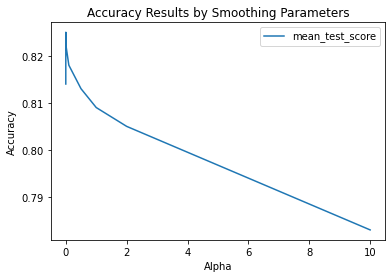

In [16]:
def Q3(alphas):

### STUDENT START ###
    """
    Input: mini & dev train data and labels and alpha values
    Purpose: understand the imact of alpha values through grid search functions
    """
    # build a Bernoulli Naive Bayes model
    bnb = BernoulliNB(binarize = 0)
    
    # create a grid search function with 5-fold cross validation
    bnb_gs = GridSearchCV(bnb, param_grid = alphas, scoring = 'accuracy', cv = 5)
    bnb_gs.fit(mini_train_data, mini_train_labels)
    bnb_gs.score(dev_data, dev_labels)
    
    # load grid search results into a dataframe and create a plot
    result = pd.DataFrame(bnb_gs.cv_results_)
    result_sorted = result.loc[:,['param_alpha', 'mean_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
    print("Best alpha = ", bnb_gs.best_params_)
    
    result.plot(x= 'param_alpha', y = 'mean_test_score')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Results by Smoothing Parameters')
    
    return result_sorted

### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


ANSWER: The best value for alpha is 0.001. The accuracy is close to 0.814 when alpha is near zero. The result indicates that smoothing data helps the accuracies, and the top 5 values for alpha are all smaller or equal to 0.1. Smoothing helps to reduce the contrast between black and white pixels, but if the smoothing factor becomes too large, the images might be too blurry and we see accuracies drop.

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [18]:
def Q4():

### STUDENT END ###
    """
    Input: mini & dev train data and labels
    Purpose: understand the imact of variable smoothing on Gaussian Naive Bayes
    """
    
    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    print('Prediction accuracy of original Gaussian Naive Bayes: %3.2f' % gnb.score(dev_data, dev_labels))
    print('Max sigma in standard GNB model features: %3.3f' % pd.DataFrame(gnb.sigma_).max().max())
    
    #Apply smoothing
    
    smoothing = {'var_smoothing': np.linspace(0.001, 1)}
    gnb_gs = GridSearchCV(gnb, param_grid = smoothing, scoring = 'accuracy', cv = 5)
    gnb_gs.fit(mini_train_data, mini_train_labels)
    
    for i in gnb_gs.best_params_.values():
        alpha = float(i)

    gnb1 = GaussianNB(var_smoothing = alpha)
    gnb1.fit(mini_train_data, mini_train_labels)
    
    print('Prediction accuracy of fixed Gaussian Naive Bayes: %3.2f' % gnb1.score(dev_data, dev_labels))
    print('Max sigma in fixed GNB model features: %3.3f' % pd.DataFrame(gnb1.sigma_).max().max())
    
### STUDENT END ###

Q4()

Prediction accuracy of original Gaussian Naive Bayes: 0.59
Max sigma in standard GNB model features: 0.212
Prediction accuracy of fixed Gaussian Naive Bayes: 0.82
Max sigma in fixed GNB model features: 0.220


ANSWER: Guassian Naive Bayes model is intended for continous features, and it does not perform well on the digital classification dataset which has very low variances. We can see the maximum sigma value is 0.212. However, after applying a smoothing factor (var_smoothing), the model yields a much better result that is almost the same as our Bernoulli Naive Bayes model.

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



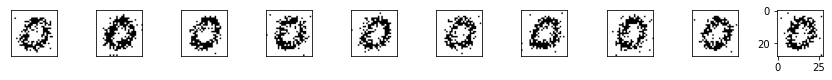

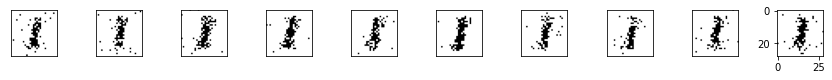

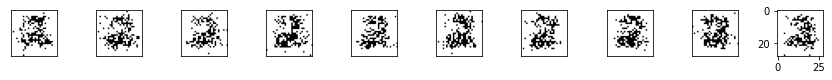

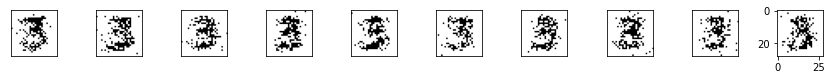

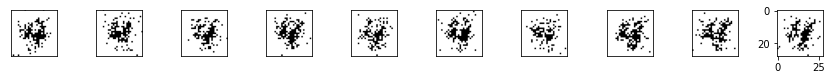

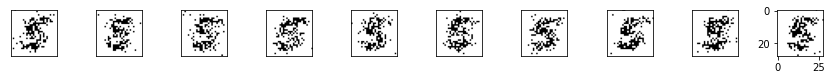

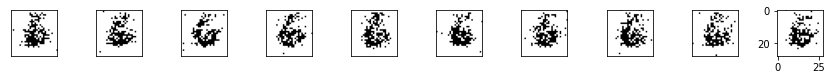

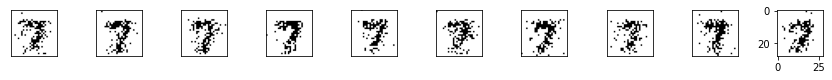

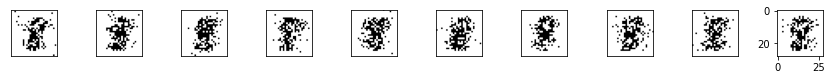

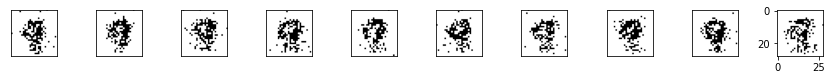

In [20]:
def Q5(num_examples):

### STUDENT START ###
    """
    Input: mini & dev train data and labels, number of examples
    Purpose: understand the generative model of Naive Bayes
    """
    # create a Bernoulli Naive Bayes model
    bnb = BernoulliNB(binarize = 0.1)
    bnb.fit(mini_train_data, mini_train_labels)
    # store the converted feature log probability
    result = np.exp(bnb.feature_log_prob_) 

    for k in range(10):   
        plt.figure(figsize = (15,10))

        for i in range(10):
            # generate random numbers from a uniform distribution
            randoms = np.random.rand(784) 
            # compare between random numbers and generated probability, true or false
            new_image = (randoms <= result[k]).astype(np.int)
            plt.xticks([])
            plt.yticks([])
            plt.subplot(10,10, i+1)
            plt.imshow(new_image.reshape(28,28), cmap = 'Greys')

        plt.show()  

### STUDENT END ###

Q5(10)

ANSWER: The general shape of generated digits looks like the digits from the training data, but it has more noises, especially for those digits that are easily misclassified, e.g., 4 and 9.

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [21]:
def Q6(buckets, correct, total):
    
### STUDENT START ###
    """
    Input: train, test data and buckets, correct and total list
    Purpose: understand the relationship between prosterior probabilites and accuracies
    """
    # create a Bernoulli Naive Bayes model
    bnb = BernoulliNB(binarize = 0, alpha = 0.001)
    bnb.fit(mini_train_data, mini_train_labels)
    dev_pred = bnb.predict(dev_data)
    # store estimated posterior probabilities of the predicted classes 
    dev_probs = bnb.predict_proba(dev_data)

    for i in range(len(dev_pred)):
        pred = dev_pred[i].astype(int) # extract predicted labels
        prob = dev_probs[i][pred] # extract predicted probability based on label index
        true = dev_labels.iloc[i] # extract true label
        k = 0 # starting point of buckets

        for j in buckets:
            if k <= prob <= j: # compare predicted probability with each bucket
                total[buckets.index(j)]+=1 # add to total count
                if pred == int(true): # compare predicted label with true label
                    correct[buckets.index(j)]+=1 # add to correct count
            k = j
            
    # print accuracy results by buckets        
    k = 0 # reset starting point of buckets   
    for j in buckets:
        if total[buckets.index(j)] == 0:
             a = 0 # avoid divisor = 0
        else:  
            a = round(correct[buckets.index(j)]/total[buckets.index(j)], 4)
        print('Between', k, 'and', j, ', total:', total[buckets.index(j)], ' and accuracy:', a)

        k = j
        
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

Between 0 and 0.5 , total: 0  and accuracy: 0
Between 0.5 and 0.9 , total: 31  and accuracy: 0.3548
Between 0.9 and 0.999 , total: 67  and accuracy: 0.4328
Between 0.999 and 0.99999 , total: 59  and accuracy: 0.4576
Between 0.99999 and 0.9999999 , total: 46  and accuracy: 0.6522
Between 0.9999999 and 0.999999999 , total: 62  and accuracy: 0.7742
Between 0.999999999 and 0.99999999999 , total: 33  and accuracy: 0.7879
Between 0.99999999999 and 0.9999999999999 , total: 43  and accuracy: 0.7907
Between 0.9999999999999 and 1.0 , total: 659  and accuracy: 0.9378


ANSWER: I would classify this Bernoulli Naive Bayes model as weakly calibrated. The accuracy does not reach 90% when it says it is 90% accurate until the last bucket, but the overall estimated posterior probability has a positive correlation with accuracy. Therefore, I think it is fair to say the model is a weakly calibrated classifier.

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [24]:
### Reference: https://towardsdatascience.com/improving-accuracy-on-mnist-using-data-augmentation-b5c38eb5a903
## I got the idea and partial codes from the link above to expand the dataset by slighly shifting the digits 

from scipy.ndimage.interpolation import shift

def Q7():

### STUDENT START ###
    """
    Input: train, test data & image shifting function
    Purpose: understand the accuracy of augmented training data
    """    
    bnb = BernoulliNB(binarize = 0, alpha = 0.0001)
    bnb.fit(mini_train_data, mini_train_labels)
    print('Accuracy of the model based on original features:', bnb.score(dev_data, dev_labels))

    # define a function to shift images
    def shift_image(image, dx, dy):  
        image = image.reshape((28, 28))
        shifted_image = shift(image, (dy, dx))
        return shifted_image.reshape([-1])

    # create augmented train and label data
    a = mini_train_data.to_numpy()
    X_train_augmented = [image for image in a]
    y_train_augmented = [image for image in mini_train_labels]
    print('Original dataset size:', len(X_train_augmented), len(y_train_augmented))

    for dx, dy in ((-0.0000001, 0.0000001), (0.0000001, -0.0000001)):
        for i in range(len(a)):
            X_train_augmented.append(shift_image(a[i], dx, dy))
            y_train_augmented.append(mini_train_labels.iloc[i])

    print('Expanded dataset size:',len(X_train_augmented), len(y_train_augmented))


    X_train_augmented = pd.DataFrame(X_train_augmented, columns = mini_train_data.columns)
    y_train_augmented = pd.Series(y_train_augmented)    
    
    bnb2 = BernoulliNB(binarize = 0.01, alpha = 0.0001)
    bnb2.fit(X_train_augmented, y_train_augmented)
    print('Accuracy of the model based on expanded dataset:', bnb2.score(dev_data, dev_labels))

### STUDENT END ###

Q7()

Accuracy of the model based on original features: 0.823
Original dataset size: 1000 1000
Expanded dataset size: 3000 3000
Accuracy of the model based on expanded dataset: 0.824
